#Import dan Download Semua Package

In [1]:
import os
import pandas as pd
import nltk, os, re, string
from keras.layers import Input, LSTM, Bidirectional, SpatialDropout1D, Dropout, Flatten, Dense, Embedding, BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
import zipfile,os,shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
!pip install -q kaggle

In [3]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"wilsonoey","key":"35bd73c0cc9203a4fc5a129e7751abc3"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [5]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d landlord/handwriting-recognition

handwriting-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!mkdir handwriting
!unzip -qq handwriting-recognition.zip -d handwriting
!ls handwriting

mkdir: cannot create directory ‘handwriting’: File exists
replace handwriting/test_v2/test/TEST_0001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
test_v2   validation_v2		    written_name_train_v2.csv
train_v2  written_name_test_v2.csv  written_name_validation_v2.csv


In [7]:
!ls handwriting

test_v2   validation_v2		    written_name_train_v2.csv
train_v2  written_name_test_v2.csv  written_name_validation_v2.csv


In [8]:
base_dir = '/content/handwriting/'

In [9]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest', 
    validation_split=0.2
)

In [10]:
test_datagen = ImageDataGenerator(
    rescale = 1./225,
    rotation_range = 20,
    horizontal_flip = True,
    vertical_flip = True,
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest', 
    validation_split=0.2
)

In [11]:
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'categorical',
    subset='training'
)

Found 330961 images belonging to 3 classes.


In [12]:
test_generator = test_datagen.flow_from_directory(
    base_dir,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'categorical',
    subset='validation'
)

Found 82740 images belonging to 3 classes.


#Membangun Model menggunakan Model Sequential

In [13]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='softmax'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='softmax'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='softmax'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='softmax'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 256)       2

#Implementasi Callback Apabila memenuhi Standar Akurasi yang Sudah Ditentukan

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if not (0 < logs.get('accuracy') < 0.92):
      self.model.stop_training = True
      print("\nAkurasi sudah di atas 92%. Selesai training!")
callbacks = myCallback()

In [15]:
history = model.fit(
    train_generator,
    steps_per_epoch = 1, # 1312 images = batch_size * steps
    epochs = 250,
    validation_data = test_generator,
    validation_steps = 1, # 876 images = batch_size * steps
    verbose =2,
      callbacks=[callbacks]
)

Epoch 1/250
1/1 - 4s - loss: 1.0971 - accuracy: 0.0938 - val_loss: 1.0950 - val_accuracy: 0.6875
Epoch 2/250
1/1 - 3s - loss: 1.0951 - accuracy: 0.7188 - val_loss: 1.0914 - val_accuracy: 0.8125
Epoch 3/250
1/1 - 3s - loss: 1.0929 - accuracy: 0.6875 - val_loss: 1.0899 - val_accuracy: 0.7188
Epoch 4/250
1/1 - 3s - loss: 1.0891 - accuracy: 0.7812 - val_loss: 1.0815 - val_accuracy: 0.9062
Epoch 5/250
1/1 - 3s - loss: 1.0865 - accuracy: 0.7500 - val_loss: 1.0831 - val_accuracy: 0.7500
Epoch 6/250
1/1 - 3s - loss: 1.0795 - accuracy: 0.8750 - val_loss: 1.0778 - val_accuracy: 0.8125
Epoch 7/250
1/1 - 3s - loss: 1.0808 - accuracy: 0.7500 - val_loss: 1.0758 - val_accuracy: 0.7812
Epoch 8/250
1/1 - 3s - loss: 1.0711 - accuracy: 0.8750 - val_loss: 1.0689 - val_accuracy: 0.8438
Epoch 9/250
1/1 - 3s - loss: 1.0705 - accuracy: 0.8125 - val_loss: 1.0800 - val_accuracy: 0.6250
Epoch 10/250
1/1 - 3s - loss: 1.0708 - accuracy: 0.7500 - val_loss: 1.0657 - val_accuracy: 0.7812
Epoch 11/250
1/1 - 3s - loss:

#Grafik Akurasi

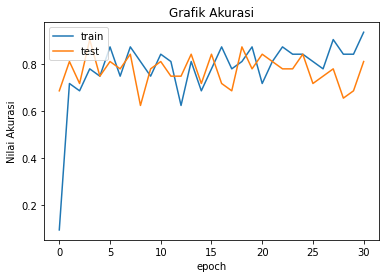

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Grafik Akurasi')
plt.ylabel('Nilai Akurasi')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Grafik Loss

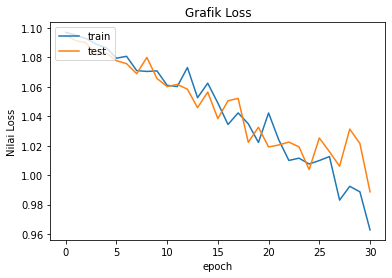

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Grafik Loss')
plt.ylabel('Nilai Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Konversi Model

In [18]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpot_lpqfs/assets


In [19]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
  f.write(tflite_model)

In [20]:
model.save('my_model.pb') 
%cd

INFO:tensorflow:Assets written to: my_model.pb/assets


INFO:tensorflow:Assets written to: my_model.pb/assets


/root
